# Install necessary packages

In [1]:
!pip install opencv-python

In [2]:
!pip install imutils

# Import required libraries

In [3]:
import os
import random

import cv2
import numpy as np
from skimage.feature import hog
from imutils import paths
from skimage import io
from skimage import exposure

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from skimage.io import imread, imshow
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Load dataset

In [4]:
imagePaths = list(paths.list_images('Dataset'))

# Display some samples from the dataset

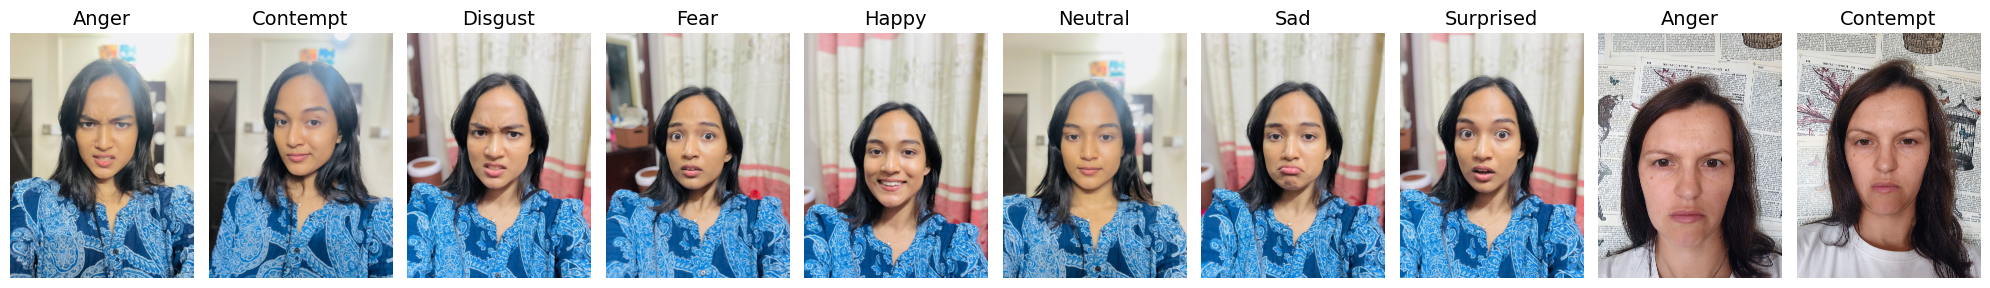

In [5]:
fig = plt.figure(figsize=(20, 10))

# Display 10 sample images with emotion labels
for i in range(10):  # Display the first 10 sample images
    fig.add_subplot(1, 10, i + 1)
    img = cv2.imread(imagePaths[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
    
    # Extract the emotion label from the filename
    emotion_label = imagePaths[i].split(os.path.sep)[-1].split('.')[0]  # Extract filename without extension
    
    # Display emotion label as the title
    plt.title(emotion_label, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing & Feature extraction

### Convert BGR to grayscale

In [6]:
def colortogray(im):
    image = cv2.imread(im)  # Read image
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    return imgray

### Resize images with a fixed size(INTER LINEAR interpolation)

In [7]:
#Resize the image to a fixed size
def resizeImage(image, size):
    return cv2.resize(image, (size, size), interpolation=cv2.INTER_LINEAR)  # Resize with interpolation

### Features extraction using HOG algorithm

In [8]:
def feature_extract(imagePaths):
    features = []  # To store HOG features
    labels = []  # To store corresponding labels

    for imagePath in imagePaths:
        # Preprocessing: Read and preprocess the image
        im = colortogray(imagePath)
        im = resizeImage(im, 128)  # Resize to 128x128 pixels

        # Extract HOG features by defining HOG parameters
        fd1 = hog(
            im,
            orientations=9,            # Number of gradient bins
            pixels_per_cell=(8, 8),    # Size of each cell in pixels
            cells_per_block=(2, 2),    # Number of cells per block
            block_norm='L2-Hys',       # Block normalization method
            transform_sqrt=False,      # No image square root transformations
            feature_vector=True,       # Return features as a single array
            visualize=False            # Do not return the visualization
        )
        
        # Extract label from image path
        label = imagePath.split(os.path.sep)[-2]  # Folder name represents the label
        labels.append(label)
        features.append(fd1)  # Append only the feature vector, not the visualization

    # Convert lists to NumPy arrays
    hog_features = np.array(features)
    labels = np.array(labels)
    return hog_features, labels

### Extracting HOG features and labels

In [9]:
hog_features, labels = feature_extract(imagePaths)

# Display results
print("Extracting HOG features from the dataset...")
print("Feature extraction completed.")
print("The number of features per sample: " + str(hog_features.shape[1]))
print(f"Extracted features for {len(hog_features)} images.")

Extracting HOG features from the dataset...
Feature extraction completed.
The number of features per sample: 8100
Extracted features for 80 images.


### Display HOG's transformation 

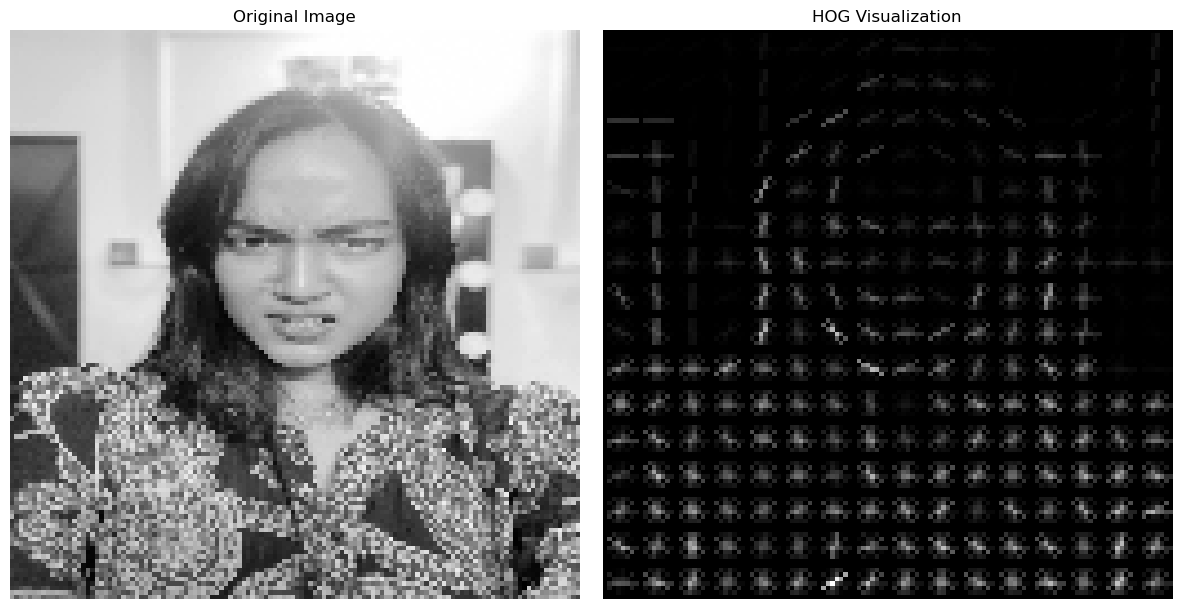

In [10]:
sample_path = imagePaths[0]  # Use the first image in the dataset

# Preprocess the image: Convert to grayscale and resize
image = colortogray(sample_path)
image_resized = resizeImage(image, 128)  # Resize to 128x128 pixels

# Compute HOG features and visualization
features, hog_image = hog(
    image_resized,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True,            # Generate HOG visualization
    transform_sqrt=True        # Apply square root normalization for visualization
)

# Rescale HOG visualization for better contrast
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot the original image and the HOG visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image_resized, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

# HOG Image
ax[1].imshow(hog_image_rescaled, cmap='gray')
ax[1].set_title("HOG Visualization")
ax[1].axis("off")

plt.tight_layout()
plt.show()

### Encode emotion labels to numerical values

In [11]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

### Feature scaling

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(hog_features)  # Scale the feature data
print(f"Scaled Features Shape: {scaled_features.shape}")

Scaled Features Shape: (80, 8100)


### Apply PCA(Principal Component Analysis)

In [13]:
pca = PCA(n_components=0.95)  # Keep 95% of variance
reduced_features = pca.fit_transform(scaled_features)
print(f"Reduced Features Shape: {reduced_features.shape}")

Reduced Features Shape: (80, 69)


# Model building & training

## Splitting dataset into training & test set

In [14]:
R =random.randint(1,100)
x_train, x_test, y_train, y_test = train_test_split(reduced_features, encoded_labels, test_size= 0.3,random_state=R)

print("The number of images used in training ..." + str(x_train.shape[0]))
print("The number of images used in testing ..." + str(x_test.shape[0]))

The number of images used in training ...56
The number of images used in testing ...24


## Initialize Support Vector Classifier Model

In [15]:
svm_model = SVC(kernel='rbf', gamma='scale', C=1, class_weight='balanced', random_state=R)   # Radial basis function kernel

## Training SVC model

In [16]:
print("Training the SVM model...")
svm_model.fit(x_train, y_train)

Training the SVM model...


SVC(C=1, class_weight='balanced', random_state=29)

# Model Evaluation

In [17]:
# Function to calculate and display accuracy
def show_accuracy(clf, x, y, train=True):
    pred = clf.predict(x)
    data_type = "Train" if train else "Test"
    print(f"{data_type} Accuracy Score: {accuracy_score(y, pred) * 100:.2f}%")

# Function to calculate and display confusion matrix
def show_confusion_matrix(clf, x, y, train=True):
    pred = clf.predict(x)
    data_type = "Train" if train else "Test"
    print(f"{data_type} Confusion Matrix:\n\n{confusion_matrix(y, pred)}\n")

# Function to calculate and display classification report
def show_classification_report(clf, x, y, train=True):
    pred = clf.predict(x)
    data_type = "Train" if train else "Test"
    print(f"{data_type} Classification Report:\n{classification_report(y, pred)}")

## Training Results

In [18]:
print("Training Result:\n==========================")
show_accuracy(svm_model, x_train, y_train, train=True)
print("\n")
show_confusion_matrix(svm_model, x_train, y_train, train=True)
print("\n")
show_classification_report(svm_model, x_train, y_train, train=True)

Training Result:
Train Accuracy Score: 100.00%


Train Confusion Matrix:

[[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 7]]



Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         7

    accuracy                           1.00        56
   macro avg 

## Testing Result

In [19]:
print("\nTesting Result:\n==========================")
show_accuracy(svm_model, x_test, y_test, train=False)
print("\n")
show_confusion_matrix(svm_model, x_test, y_test, train=False)
print("\n")
show_classification_report(svm_model, x_test, y_test, train=False)


Testing Result:
Test Accuracy Score: 91.67%


Test Confusion Matrix:

[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 1]
 [0 1 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 1]]



Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      0.80      0.89         5
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         2
           9       0.50      1.00      0.67         1

    accuracy                           0.92        24
   macro avg     

## Cross-validation accuracy

### 3-FOLDS

In [20]:
cv = KFold(n_splits=3, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(svm_model, reduced_features, encoded_labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance

print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN  Accuracy:  78.82%
Standard deviation:  14.21%


### 5-FOLDS

In [21]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(svm_model, reduced_features, encoded_labels, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance

print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN  Accuracy:  97.5%
Standard deviation:  5.0%
